Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

# импорт библиотек и новые функции

In [129]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
import re #регулярные выражения
import numpy as np
from nltk.corpus import stopwords #стоп слова- не несут смысла но часто встречаются
from razdel import tokenize # https://github.com/natasha/razdel
import pymorphy2  # pip install pymorphy2
from gensim.models import LdaModel # тематическая модель
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [130]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [131]:
#Давайте напишем функцию, которая будет нам возвращать векторное представление новости
#text = news['title'].iloc[0]
# функция которая для документов вытаскивает распределение топиков
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(30):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [132]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Наши новости

In [133]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [134]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [135]:
stopword_ru = stopwords.words('russian')
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
stopword_ru.append('nn')

morph = pymorphy2.MorphAnalyzer()

In [136]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 27.6 s, sys: 857 ms, total: 28.5 s
Wall time: 29 s


In [137]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 24s, sys: 2.22 s, total: 4min 26s
Wall time: 4min 30s


А теперь в 3 строчки обучим нашу модель

In [138]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [139]:
common_dictionary[10]

'взаимодействие'

Все просто - это словарь наших слов

Запускаем обучение

In [140]:
%%time

# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=30, id2word=common_dictionary)#, passes=10)

CPU times: user 48.2 s, sys: 2.69 s, total: 50.9 s
Wall time: 34.2 s


Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [141]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]] #взяли первые 3 документа
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]
#
unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] # получаем распределение тем

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.095481925),
 (14, 0.025123),
 (15, 0.6275554),
 (23, 0.09996662),
 (26, 0.12987949)]

In [142]:
x=lda.show_topics(num_topics=30, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
# вывести топ 7 слов для темы
#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: экипаж маршрут вирус км флот небо порт
topic_1: температура строительство градус ремонт край реконструкция департамент
topic_2: украина украинский рак киев россия ссср российский
topic_3: взрыв турция египет турецкий доклад миллиард активность
topic_4: рубль размер тыс следствие испытание срок тысяча
topic_5: военный сша россия американский российский эксперт технология
topic_6: россия российский сша государство глава санкция решение
topic_7: обнаружить пациент мужчина задержать аэропорт участок пилот
topic_8: фестиваль мероприятие сайт греция гость подробность состояться
topic_9: земля свет улица долг вицепремьер медведев снять
topic_10: остров вода китай конкурс китайский супруг констатировать
topic_11: район центр территория житель операция станция погибнуть
topic_12: ракета проект миссия земля новый минимальный применение
topic_13: россиянин место писать гражданин определение пилотировать рекорд
topic_14: исследование ребёнок гражданин изменение власть всё способ
topic_15:

In [143]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(30)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(30)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,6,0.0,0.00000,0.00000,0.000000,0.000000,0.0000,0.0,0.0,0.0,...,0.881532,0.0,0.0,0.000000,0.0,0.0,0.017201,0.0,0.0,0.0
1,4896,0.0,0.00000,0.00000,0.630544,0.000000,0.0000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,4897,0.0,0.00000,0.09528,0.000000,0.000000,0.0000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.099987,0.0,0.0,0.129909,0.0,0.0,0.0
3,4898,0.0,0.00000,0.00000,0.000000,0.038432,0.2763,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.317023,0.0,0.0,0.000000,0.0,0.0,0.0
4,4899,0.0,0.46966,0.00000,0.000000,0.000000,0.0000,0.0,0.0,0.0,...,0.429137,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [144]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [145]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(30)]].values))

In [146]:
doc_dict[293622]

array([0.04280401, 0.        , 0.1518189 , 0.06367054, 0.        ,
       0.        , 0.250431  , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04977587, 0.        , 0.        ,
       0.04335489, 0.07687835, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.15367758, 0.10345259, 0.        ,
       0.        , 0.        , 0.        , 0.02348077, 0.02971339])

In [147]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [148]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [149]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [150]:
get_user_embedding_mean(user_articles_list)

array([0.0029971 , 0.        , 0.05895065, 0.        , 0.06227547,
       0.1305553 , 0.24694429, 0.04818967, 0.00210412, 0.00227247,
       0.01352359, 0.02685804, 0.00935049, 0.        , 0.04675905,
       0.        , 0.0570988 , 0.03007254, 0.00230113, 0.        ,
       0.06516119, 0.00201277, 0.02646395, 0.04959641, 0.00555304,
       0.02278683, 0.00986138, 0.00228446, 0.00662865, 0.05245236])

In [151]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08451425, 0.19779007, 0.        , 0.        , 0.        ,
       0.        , 0.01850632, 0.        , 0.        , 0.03354618,
       0.        , 0.01336406, 0.        , 0.        , 0.        ,
       0.00822229, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02391673])

In [152]:
get_user_embedding_max(user_articles_list)

array([0.01798262, 0.        , 0.20288745, 0.        , 0.37365285,
       0.36920929, 0.46616429, 0.26707768, 0.01262472, 0.01363484,
       0.08114154, 0.08708286, 0.05610292, 0.        , 0.1079338 ,
       0.        , 0.1687291 , 0.12151685, 0.01380678, 0.        ,
       0.250833  , 0.01207661, 0.15878367, 0.29757848, 0.03331827,
       0.11348157, 0.02964302, 0.01370678, 0.03977191, 0.17003326])

##### Интересовался новостями с топиками topic____ (что-то про политику и государство)

In [153]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [154]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать барак 

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [155]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(30)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(30)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,u105138,0.007134,0.030392,0.131801,0.039372,0.003206,0.019853,0.143914,0.006727,0.033984,...,0.025498,0.0,0.030412,0.057344,0.005552,0.011152,0.039388,0.021051,0.008986,0.031469
1,u108690,0.000000,0.000000,0.134926,0.035627,0.024379,0.063111,0.179142,0.009051,0.005719,...,0.068063,0.0,0.034376,0.070825,0.000000,0.000000,0.000000,0.000000,0.025121,0.070579
2,u108339,0.002408,0.016263,0.026366,0.007718,0.044416,0.070233,0.165018,0.034776,0.001752,...,0.046066,0.0,0.052720,0.052789,0.003571,0.001835,0.002102,0.006374,0.037720,0.111372


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [156]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [157]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,churn
0,u105138,0.007134,0.030392,0.131801,0.039372,0.003206,0.019853,0.143914,0.006727,0.033984,...,0.0,0.030412,0.057344,0.005552,0.011152,0.039388,0.021051,0.008986,0.031469,0
1,u108690,0.000000,0.000000,0.134926,0.035627,0.024379,0.063111,0.179142,0.009051,0.005719,...,0.0,0.034376,0.070825,0.000000,0.000000,0.000000,0.000000,0.025121,0.070579,1
2,u108339,0.002408,0.016263,0.026366,0.007718,0.044416,0.070233,0.165018,0.034776,0.001752,...,0.0,0.052720,0.052789,0.003571,0.001835,0.002102,0.006374,0.037720,0.111372,1


In [158]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(30)]], 
                                                    X['churn'], random_state=0)

In [159]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [160]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.14938322, 0.03677459, 0.39671632, 0.11068428, 0.13088373,
       0.03318778, 0.08654481, 0.02041996, 0.21393185, 0.0665696 ])

### Рассчитаем Precision, Recall, F_score

In [161]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.252467, F-Score=0.679, Precision=0.635, Recall=0.731


In [162]:
fscore1 = round(fscore[ix], 3)
precision1 = round(precision[ix], 3)
recall1 = round(recall[ix], 3)

Confusion matrix, without normalization
[[1652  103]
 [  67  178]]


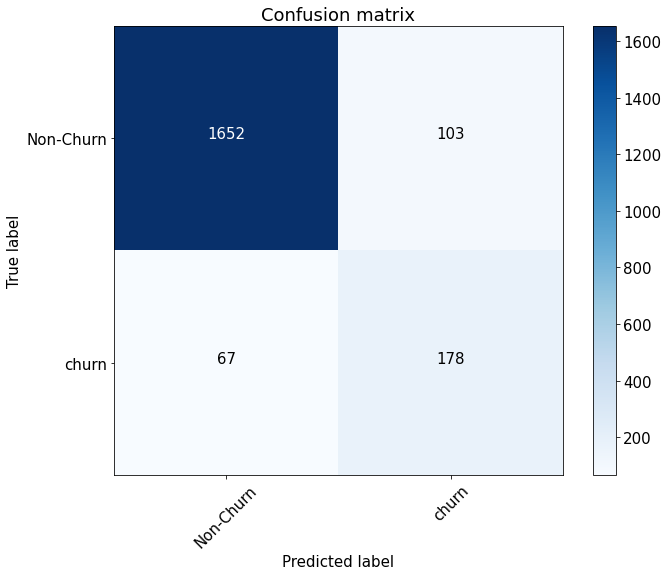

In [163]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [164]:
roc_auc_score(y_test, preds)

0.9481062852491423

In [165]:
roc_auc_score1 = roc_auc_score(y_test, preds)

In [166]:
# median
user_embeddings2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings2.columns = ['topic_{}'.format(i) for i in range(30)]
user_embeddings2['uid'] = users['uid'].values
user_embeddings2 = user_embeddings2[['uid']+['topic_{}'.format(i) for i in range(30)]]
user_embeddings2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,u105138,0.0,0.000000,0.082579,0.031835,0.000000,0.000000,0.163056,0.000000,0.0,...,0.000000,0.0,0.000000,0.051726,0.0,0.0,0.0,0.0,0.000000,0.014857
1,u108690,0.0,0.000000,0.128341,0.007750,0.010567,0.073765,0.123783,0.000000,0.0,...,0.077099,0.0,0.028099,0.061378,0.0,0.0,0.0,0.0,0.006024,0.041249
2,u108339,0.0,0.008186,0.017049,0.000000,0.038354,0.025308,0.192597,0.006825,0.0,...,0.036889,0.0,0.060479,0.038141,0.0,0.0,0.0,0.0,0.031357,0.135778


In [167]:
X2 = pd.merge(user_embeddings2, target, 'left')
X2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,churn
0,u105138,0.0,0.000000,0.082579,0.031835,0.000000,0.000000,0.163056,0.000000,0.0,...,0.0,0.000000,0.051726,0.0,0.0,0.0,0.0,0.000000,0.014857,0
1,u108690,0.0,0.000000,0.128341,0.007750,0.010567,0.073765,0.123783,0.000000,0.0,...,0.0,0.028099,0.061378,0.0,0.0,0.0,0.0,0.006024,0.041249,1
2,u108339,0.0,0.008186,0.017049,0.000000,0.038354,0.025308,0.192597,0.006825,0.0,...,0.0,0.060479,0.038141,0.0,0.0,0.0,0.0,0.031357,0.135778,1


In [168]:
#разделим данные на train/test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2[['topic_{}'.format(i) for i in range(30)]], 
                                                    X2['churn'], random_state=0)

In [169]:
logreg2 = LogisticRegression()
#обучим наш пайплайн
logreg2.fit(X_train2, y_train2)

LogisticRegression()

In [170]:
#наши прогнозы для тестовой выборки
preds2 = logreg2.predict_proba(X_test2)[:, 1]
preds2[:10]

array([0.13243727, 0.05286622, 0.56844678, 0.05281504, 0.05079252,
       0.02193101, 0.07102789, 0.01111548, 0.27208352, 0.07006819])

In [171]:
precision, recall, thresholds = precision_recall_curve(y_test2, preds2)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.295411, F-Score=0.811, Precision=0.835, Recall=0.788


In [172]:
fscore2 = round(fscore[ix], 3)
precision2 = round(precision[ix], 3)
recall2 = round(recall[ix], 3)

Confusion matrix, without normalization
[[1717   38]
 [  53  192]]


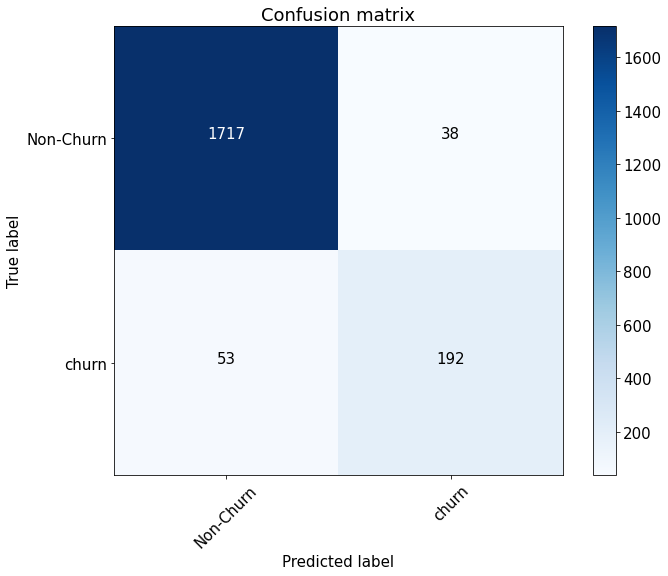

In [173]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test2, preds2>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [174]:
roc_auc_score(y_test2, preds2)

0.9804058375486947

In [175]:
roc_auc_score2 = roc_auc_score(y_test2, preds2)

In [187]:
#max
user_embeddings3 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings3.columns = ['topic_{}'.format(i) for i in range(30)]
user_embeddings3['uid'] = users['uid'].values
user_embeddings3 = user_embeddings3[['uid']+['topic_{}'.format(i) for i in range(30)]]
user_embeddings3.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,u105138,0.042804,0.182355,0.334120,0.095387,0.019238,0.119116,0.250431,0.040361,0.203906,...,0.152989,0.0,0.153678,0.121737,0.033311,0.066912,0.153950,0.097366,0.030434,0.080131
1,u108690,0.000000,0.000000,0.281003,0.180912,0.095895,0.114761,0.550959,0.031236,0.034315,...,0.099865,0.0,0.083674,0.176950,0.000000,0.000000,0.000000,0.000000,0.095204,0.240827
2,u108339,0.014448,0.057834,0.091342,0.028988,0.091566,0.294062,0.295568,0.097534,0.010514,...,0.129163,0.0,0.101243,0.157379,0.011036,0.011009,0.012612,0.019750,0.081935,0.194904


In [188]:
X3 = pd.merge(user_embeddings3, target, 'left')
X3.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,churn
0,u105138,0.042804,0.182355,0.334120,0.095387,0.019238,0.119116,0.250431,0.040361,0.203906,...,0.0,0.153678,0.121737,0.033311,0.066912,0.153950,0.097366,0.030434,0.080131,0
1,u108690,0.000000,0.000000,0.281003,0.180912,0.095895,0.114761,0.550959,0.031236,0.034315,...,0.0,0.083674,0.176950,0.000000,0.000000,0.000000,0.000000,0.095204,0.240827,1
2,u108339,0.014448,0.057834,0.091342,0.028988,0.091566,0.294062,0.295568,0.097534,0.010514,...,0.0,0.101243,0.157379,0.011036,0.011009,0.012612,0.019750,0.081935,0.194904,1


In [189]:
#разделим данные на train/test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3[['topic_{}'.format(i) for i in range(30)]], 
                                                    X3['churn'], random_state=0)

In [190]:
logreg3 = LogisticRegression()
#обучим наш пайплайн
logreg3.fit(X_train3, y_train3)

LogisticRegression()

In [191]:
#наши прогнозы для тестовой выборки
preds3 = logreg3.predict_proba(X_test3)[:, 1]
preds3[:10]

array([0.16361334, 0.00411235, 0.47675509, 0.27134136, 0.02017579,
       0.01869784, 0.10160486, 0.00194262, 0.08263036, 0.06300424])

In [192]:
precision, recall, thresholds = precision_recall_curve(y_test3, preds3)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.399324, F-Score=0.799, Precision=0.894, Recall=0.722


In [193]:
fscore3 = round(fscore[ix], 3)
precision3 = round(precision[ix], 3)
recall3 = round(recall[ix], 3)

Confusion matrix, without normalization
[[1734   21]
 [  69  176]]


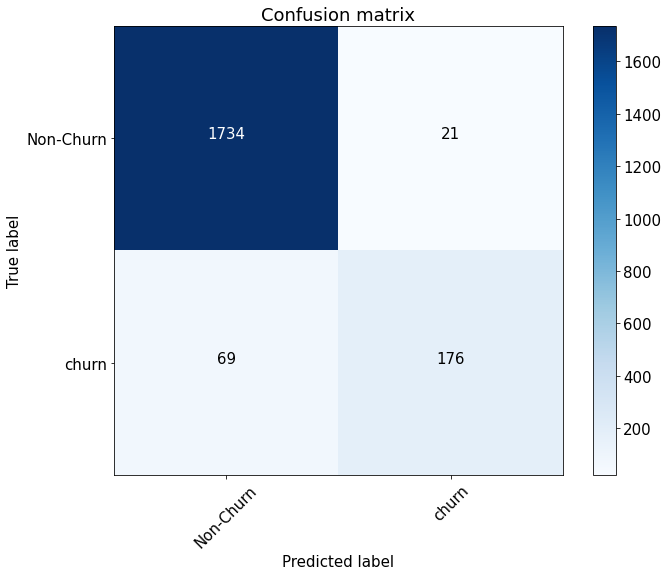

In [194]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test3, preds3>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [195]:
roc_auc_score(y_test3, preds3)

0.9734147334147334

In [196]:
roc_auc_score3 = roc_auc_score(y_test3, preds3)

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

По результатам 

In [197]:
result = {"F-Score":np.array([fscore1, fscore2, fscore3]),
          "Precision":np.array([precision1, precision2, precision3]),
          "Recall":np.array([recall1, recall2, recall3]),
        "roc_auc_score": np.array([roc_auc_score1, roc_auc_score2, roc_auc_score3])}

results = pd.DataFrame(result, index=['mean', 'median', 'max'])
print(results)


        F-Score  Precision  Recall  roc_auc_score
mean      0.679      0.635   0.731       0.948106
median    0.811      0.835   0.788       0.980406
max       0.799      0.894   0.722       0.973415


Таким образом, получаем, что лучшее качество достигается при использовании медианы при составлении векртора пользователя.
Происходит это потому что:
- при использовании среднего значения усредняются
- при использовании медианы - значения имеют "больший вес" чем в случае со средним, так как берется значение в середине, но оно к тому же более показательно чем максимум
- при использовании максимума берутся максимальные значения, а все остальные не берутся в рассчет, хотя тоже влияют